<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/02_backtesting_risk_management/W6_backtrader_risk_management1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risk Management

This notebook is focused on risk management strategies like stop losses, max drawdown and take profits.

Moreover we try to implemetn different strategies and maybe start introducing multiasset strategies.

## Single Asset - RSI Strategies

To spice up a bit the work we have performed on week 5, let's use a different strategy than MA crossovers.

In [ ]:
!pip install backtrader
#importing the library with alias bt
import backtrader as bt
#importing otehr libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os.path
import sys
import seaborn as sns
#DATA saved locally for testing to limit yf API usage
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive')
path = "/content/drive/My Drive/QUANT/DATA/"
print("Files in project folder:", os.listdir(path))

position_pct = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in project folder: ['btc_1d_data_2018_to_2025.csv', 'btc_1h_data_2018_to_2025.csv']


### 5% Positioning - Base

In [ ]:
class RSIStrategy(bt.Strategy):
  params = dict(rsi_period = 14, rsi_ovs = 30, rsi_ovb = 70,)

  def __init__(self):
    self.rsi = bt.ind.RSI(self.data.close, period = self.p.rsi_period)
    self.order = None
    self.logs = [] #list to store the logs

  def log(self, event, price = None, size = None, pnl = None):
    dt = self.datas[0].datetime.datetime(0).isoformat()
    self.logs.append({
        'date': dt,
        'event': event,
        'price': round(price,2) if price else None,
        'size': round(size,2) if size else None,
        'pnl': round(pnl,2) if pnl else None
    })

  def notify_order(self,order):
    if order.status in [order.Submitted, order.Accepted]:
      return
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED', price = order.executed.price, size = order.executed.size)
      elif order.issell():
        self.log('SELL EXECUTED', price = order.executed.price, size = order.executed.size)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('ORDER CALCELED/REJECTED')
    self.order = None

  def notify_trade(self, trade):
    if trade.isclosed:
      self.log('TRADE CLOSED', pnl = trade.pnlcomm)

  def next(self):
    if self.order:
      return
    if not self.position:
      if self.rsi[0] < self.p.rsi_ovs:
          self.log('BUY SIGNAL', self.data.close[0])
          self.order = self.buy()
    else:
      if self.rsi[0] > self.p.rsi_ovb:
          self.log('SELL SIGNAL', self.data.close[0])
          self.order = self.sell()


In [ ]:
#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1h_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = data.loc['2024-01-01':] #filerinng only 1 year
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(RSIStrategy)
#add cash and broker commission
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.001)
#we can simply add a sizer as a percentage of the available cash

cerebro.addsizer(bt.sizers.PercentSizer, percents=position_pct) #use 95% of the liquidity

#run
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
results1 = cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 1000000.00
Final Value: 1013132.83


In [ ]:
logs_df1 = pd.DataFrame(results1[0].logs)
logs_df1

,date,event,price,size,pnl
0,2024-01-03T12:00:00,BUY SIGNAL,42789.38,NaN,NaN
1,2024-01-03T13:00:00,BUY EXECUTED,42789.39,1.17,NaN
2,2024-01-08T12:00:00,SELL SIGNAL,45111.09,NaN,NaN
3,2024-01-08T13:00:00,SELL EXECUTED,45111.10,-1.17,NaN
4,2024-01-08T13:00:00,TRADE CLOSED,NaN,NaN,2610.24
...,...,...,...,...,...
212,2025-05-01T10:00:00,SELL SIGNAL,96169.01,NaN,NaN
213,2025-05-01T11:00:00,SELL EXECUTED,96169.01,-0.54,NaN
214,2025-05-01T11:00:00,TRADE CLOSED,NaN,NaN,1601.93
215,2025-05-04T23:00:00,BUY SIGNAL,94277.62,NaN,NaN


### 5% Position - TP5%-SL3%

In [ ]:
class RSIStrategy(bt.Strategy):
  params = dict(rsi_period = 14, rsi_ovs = 30, rsi_ovb = 70,sl = 0.03, tp = 0.05) #3 and 5% sl and tp

  def __init__(self):
    self.rsi = bt.ind.RSI(self.data.close, period = self.p.rsi_period)
    self.order = None
    self.entry_price = None
    self.logs = [] #list to store the logs

  def log(self, event, price = None, size = None, pnl = None):
    dt = self.datas[0].datetime.datetime(0).isoformat()
    self.logs.append({
        'date': dt,
        'event': event,
        'price': round(price,2) if price else None,
        'size': round(size,2) if size else None,
        'pnl': round(pnl,2) if pnl else None
    })

  def notify_order(self,order):
    if order.status in [order.Submitted, order.Accepted]:
      return
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED', price = order.executed.price, size = order.executed.size)
        self.entry_price = order.executed.price
      elif order.issell():
        self.log('SELL EXECUTED', price = order.executed.price, size = order.executed.size)
        self.entry_price = None
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('ORDER CALCELED/REJECTED')
    self.order = None

  def notify_trade(self, trade):
    if trade.isclosed:
      self.log('TRADE CLOSED', pnl = trade.pnlcomm)

  def next(self):
    if self.order:
      return
    if not self.position:
      if self.rsi[0] < self.p.rsi_ovs:
          self.log('BUY SIGNAL', self.data.close[0])
          self.order = self.buy()
    else: #modified here
      price_now = self.data.close[0] #get price in this candlestick closse
      if self.entry_price: #if we long
          if price_now <= self.entry_price * (1-self.p.sl): #if price now hits SL
            self.log('SL HIT', price = price_now)
            self.order = self.sell() #tehen sell
          elif price_now >= self.entry_price * (1+self.p.tp): #if price now hits TP
            self.log('TP HIT', price = price_now)
            self.order = self.sell() #then sell

      elif self.rsi[0] > self.p.rsi_ovb:
          self.log('SELL SIGNAL', self.data.close[0])
          self.order = self.sell()


In [ ]:
#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1h_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = data.loc['2024-01-01':] #filerinng only 1 year
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(RSIStrategy)
#add cash and broker commission
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.001)
#we can simply add a sizer as a percentage of the available cash

cerebro.addsizer(bt.sizers.PercentSizer, percents=position_pct) #use 95% of the liquidity

#run
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
results2 = cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())


Starting Value: 1000000.00
Final Value: 1015564.99


### 5% Position - Trailing SL5%

In [ ]:
class RSIStrategy(bt.Strategy):
  params = dict(rsi_period = 14, rsi_ovs = 30, rsi_ovb = 70,trailing_sl = 0.05) #5% trailing sl

  def __init__(self):
    self.rsi = bt.ind.RSI(self.data.close, period = self.p.rsi_period)
    self.order = None
    self.logs = [] #list to store the logs
    self.trades = [] #trades
    self.current_trade = {}

  def log(self, event, price = None, size = None, pnl = None):
    dt = self.datas[0].datetime.datetime(0).isoformat()
    self.logs.append({
        'date': dt,
        'event': event,
        'price': round(price,2) if price else None,
        'size': round(size,2) if size else None,
        'pnl': round(pnl,2) if pnl else None
    })

  def notify_order(self,order):
    if order.status in [order.Submitted, order.Accepted]:
      return
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED', price = order.executed.price, size = order.executed.size)
        self.entry_price = order.executed.price
      elif order.issell():
        self.log('SELL EXECUTED', price = order.executed.price, size = order.executed.size)
        self.entry_price = None
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('ORDER CALCELED/REJECTED')
    self.order = None

  def notify_trade(self, trade):
    if trade.isclosed:
      self.log('TRADE CLOSED', pnl = trade.pnlcomm)

  def next(self):
    if self.order:
      return
    if not self.position:
      if self.rsi[0] < self.p.rsi_ovs:
          self.log('BUY SIGNAL', self.data.close[0])
          self.order = self.buy()
    else:
      self.log('SELL SIGNAL — TRAILING STOP SET', self.data.close[0])
      self.order = self.sell(
                    exectype=bt.Order.StopTrail,
                    trailpercent=self.p.trailing_sl)

In [ ]:
#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1h_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = data.loc['2024-01-01':] #filerinng only 1 year
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(RSIStrategy)
#add cash and broker commission
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.001)
#we can simply add a sizer as a percentage of the available cash

cerebro.addsizer(bt.sizers.PercentSizer, percents=position_pct) #use 95% of the liquidity

#run
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
results3 = cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())
logs_df3 = pd.DataFrame(results3[0].logs)
logs_df3

Starting Value: 1000000.00
Final Value: 1021962.85


,date,event,price,size,pnl
0,2024-01-03T12:00:00,BUY SIGNAL,42789.38,NaN,NaN
1,2024-01-03T13:00:00,BUY EXECUTED,42789.39,1.17,NaN
2,2024-01-03T13:00:00,SELL SIGNAL — TRAILING STOP SET,42529.40,NaN,NaN
3,2024-01-10T12:00:00,SELL EXECUTED,44717.84,-1.17,NaN
4,2024-01-10T12:00:00,TRADE CLOSED,NaN,NaN,2151.17
...,...,...,...,...,...
393,2025-04-10T15:00:00,SELL EXECUTED,79120.08,-0.67,NaN
394,2025-04-10T15:00:00,TRADE CLOSED,NaN,NaN,2624.42
395,2025-04-16T00:00:00,BUY SIGNAL,83146.01,NaN,NaN
396,2025-04-16T01:00:00,BUY EXECUTED,83146.01,0.61,NaN


modified just to have the log table as per trade, its just me i want to visualize it in a different way!


### Summary

In [ ]:
def trade_metrics(df):
    df = df.reset_index(drop=True).copy()
    df['date'] = pd.to_datetime(df['date'])

    trade_data = []
    i = 0
    while i < len(df):
        if df.loc[i, 'event'] == 'BUY EXECUTED':
            buy_price = df.loc[i, 'price']
            buy_date = df.loc[i, 'date']
            size = df.loc[i, 'size']
            # look ahead for TRADE CLOSED
            j = i + 1
            while j < len(df) and df.loc[j, 'event'] != 'TRADE CLOSED':
                j += 1
            if j < len(df):  # found a closing trade
                sell_date = df.loc[j - 1, 'date']  # assume SELL EXECUTED precedes TRADE CLOSED
                pnl = df.loc[j, 'pnl']
                pct_return = (pnl / buy_price) * 100 if pd.notna(pnl) and buy_price else None
                duration_hr = (sell_date - buy_date).total_seconds() / 3600

                trade_data.append({
                    'buy_price': buy_price,
                    'pnl': pnl,
                    'pct_return': pct_return,
                    'duration_hr': duration_hr
                })
                i = j + 1  # move past TRADE CLOSED
            else:
                break
        else:
            i += 1

    trades_df = pd.DataFrame(trade_data)

    winning = trades_df[trades_df['pnl'] > 0]
    losing = trades_df[trades_df['pnl'] < 0]
    cash = cerebro.broker.get_cash()
    traded_cash_pct = position_pct/100 #5% of value per trade
    norm_pnl = cash * traded_cash_pct

    summary = {
        'total_trades': len(trades_df),
        'winning_percentage': len(winning) / len(trades_df) * 100 if len(trades_df) else 0,
        'avg_%_win': winning['pct_return'].mean() if not winning.empty else 0,
        'avg_%_loss': losing['pct_return'].mean() if not losing.empty else 0,
        'total_%_pnl': trades_df['pnl'].sum()*100/norm_pnl,
        'avg_trade_duration_hr': trades_df['duration_hr'].mean() if not trades_df.empty else 0
    }

    return summary


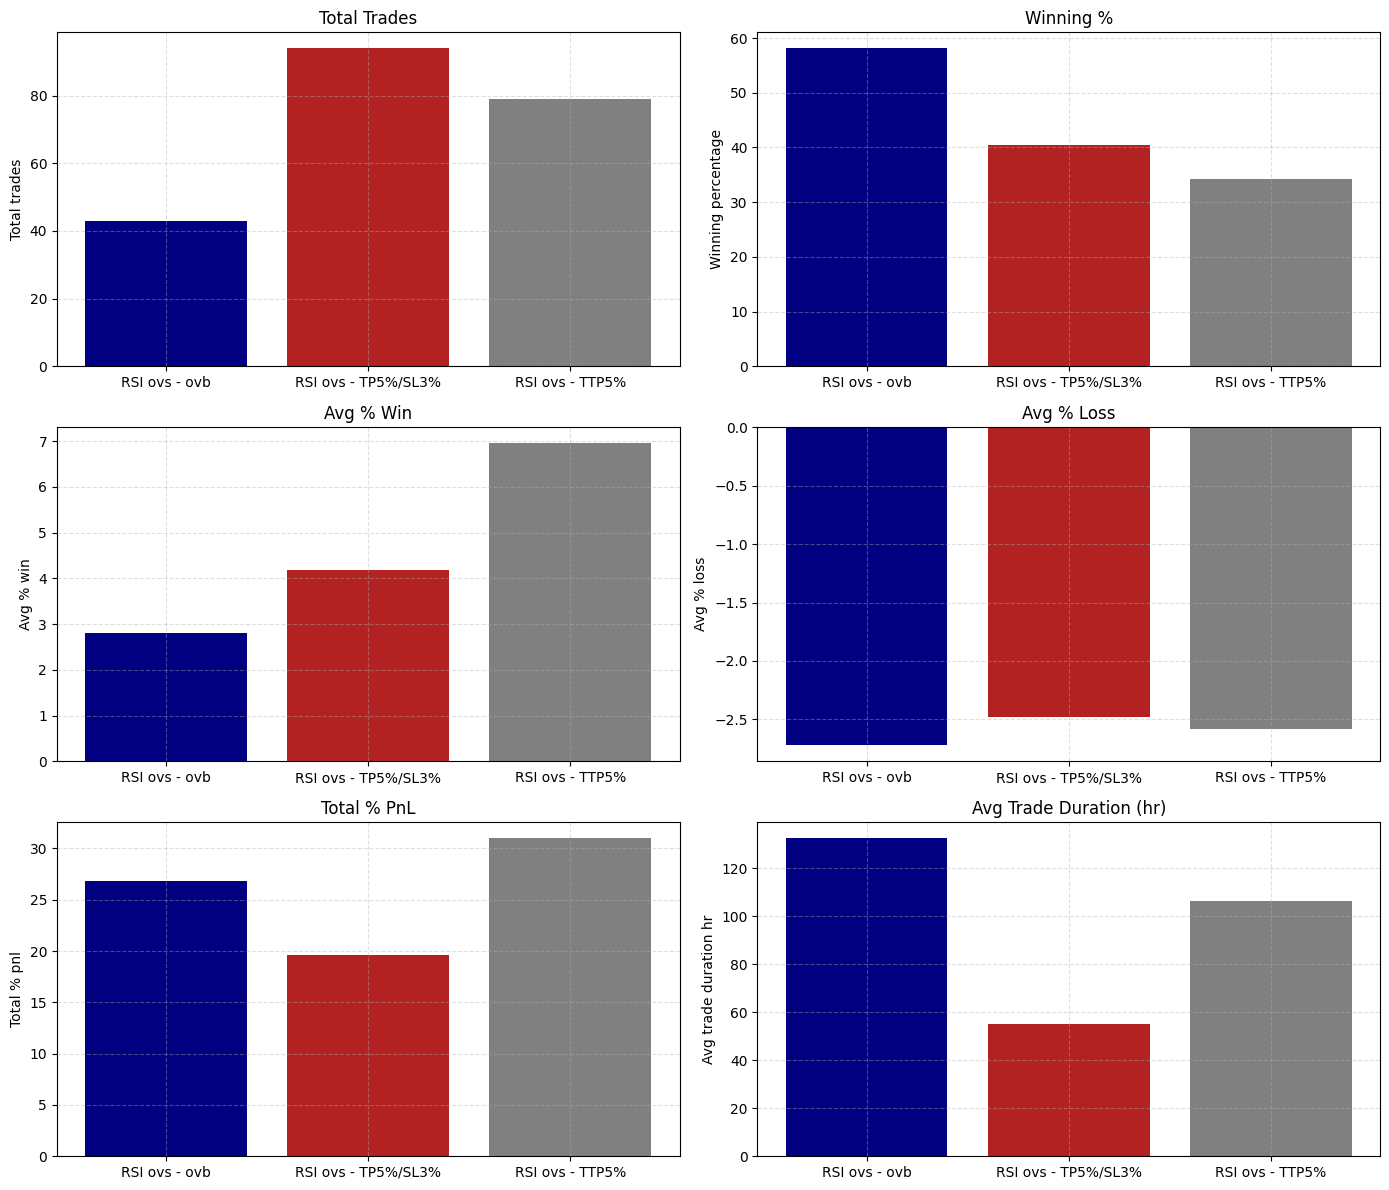

In [ ]:
# Run trade_metrics on each DataFrame
summary1 = trade_metrics(logs_df1)
summary2 = trade_metrics(logs_df2)
summary3 = trade_metrics(logs_df3)

# Collect all results into a dictionary
summaries = {
    "RSI ovs - ovb": summary1,
    "RSI ovs - TP5%/SL3%": summary2,
    "RSI ovs - TTP5%": summary3
}

# Stats to plot
metrics_to_plot = [
    "total_trades",
    "winning_percentage",
    "avg_%_win",
    "avg_%_loss",
    "total_%_pnl",
    "avg_trade_duration_hr"
]

titles = {
    "total_trades": "Total Trades",
    "winning_percentage": "Winning %",
    "avg_%_win": "Avg % Win",
    "avg_%_loss": "Avg % Loss",
    "total_%_pnl": "Total % PnL",
    "avg_trade_duration_hr": "Avg Trade Duration (hr)"
}

# Setup 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics_to_plot):
    values = [summaries[strategy][metric] for strategy in summaries]
    axs[i].bar(summaries.keys(), values, color=['navy', 'firebrick', 'gray'])
    axs[i].set_title(titles[metric])
    axs[i].set_ylabel(metric.replace('_', ' ').capitalize())
    axs[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


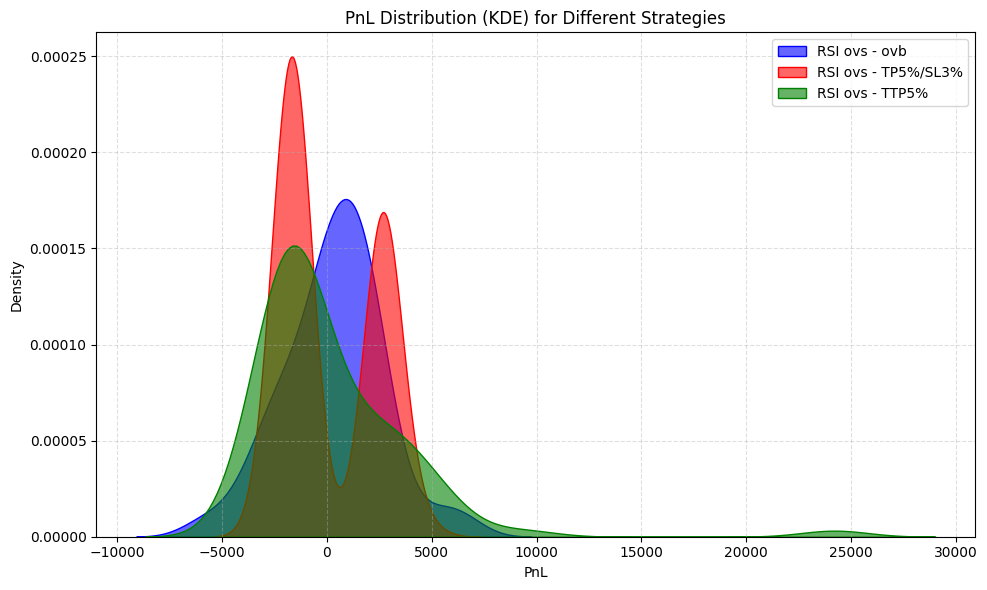

In [ ]:
def plot_pnl_distribution_for_all_strategies(trades_df1, trades_df2, trades_df3):
    # Extract the pnl data for each strategy's trades DataFrame
    pnl_data1 = trades_df1['pnl']
    pnl_data2 = trades_df2['pnl']
    pnl_data3 = trades_df3['pnl']

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot KDE for each strategy
    sns.kdeplot(pnl_data1, color='blue', fill=True, label='RSI ovs - ovb', alpha=0.6)
    sns.kdeplot(pnl_data2, color='red', fill=True, label='RSI ovs - TP5%/SL3%', alpha=0.6)
    sns.kdeplot(pnl_data3, color='green', fill=True, label='RSI ovs - TTP5%', alpha=0.6)

    # Set titles and labels
    plt.title('PnL Distribution (KDE) for Different Strategies')
    plt.xlabel('PnL')
    plt.ylabel('Density')

    # Add legend
    plt.legend()

    # Show grid
    plt.grid(True, linestyle='--', alpha=0.4)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_pnl_distribution_for_all_strategies(logs_df1, logs_df2, logs_df3)

## What happens if we start in a random period?

ok but here we selcted a specific period... what if we randomize the starting date? Should i ranodmize the ending date too...